In [1]:
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
import pickle

from census import Census
import sys, os
import numpy as np
from sklearn.decomposition import PCA
sys.path.append('../dataset/safegraph/')
import matplotlib.pyplot as plt

sys.path.append('../train')
from models import *

root = '/mnt/e/julia/regional-representations-graph-model/'

In [2]:
with open(root + 'dataset/api_keys/census_key.txt', 'r') as f:
    key = f.readline()
c = Census(key)

state_fps = ['42', '34', '36','25']

var = ['NAME', 'B01001_001E', 'B01001_026E', 'B01001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E', 'B02001_007E', 
        'B01001H_001E', 'B01001I_001E', 'B01002_001E', 'B19013_001E', 'B19083_001E', 'B27001_001E', 
        'B08101_009E', 'B08101_017E', 'B08101_025E', 'B08101_033E', 'B08101_049E', 'B15003_017E',
           'B15003_022E', 'B15003_023E', 'B15003_025E']

name = ['NAME', 'total_pop',  'num_women', 'num_men', 'total_black', 'total_na', 'total_asian', 'total_paisl', 
        'total_other', 'total_white', 'total_latino', 'total_median_age', 'median_household_income', 
        'income_gini_index', 'health_insurance_coverage', 'num_drive_alone', 
        'num_carpool', 'num_public_transit', 'num_walk', 'num_wfh', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree']

name_compute_ratio = ['num_women', 'num_men', 'total_black', 'total_na', 'total_asian', 'total_paisl', 'total_other', 'total_white', 'total_latino', 'health_insurance_coverage', 
                      'num_drive_alone', 'num_carpool', 'num_public_transit', 'num_walk', 'num_wfh', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree']

cols = name + ['state', 'county', 'tract']
census_df = pd.DataFrame(columns=cols)
for state in state_fps:
    census = c.acs5.state_county_tract(fields = var,
                                        state_fips = state,
                                        county_fips = '*',
                                        tract = "*",
                                        year = 2020)
    
    df = pd.DataFrame(census)
    df.rename(columns=dict(zip(var, name)), inplace=True)
    for col in name_compute_ratio:
        df[col] = df[col]/df['total_pop']
        
    # combine embeddings with labels
    df['GEOID'] = df['state'].astype(str) + df['county'].astype(str) + df['tract'].astype(str)
        
    census_df = pd.concat([census_df, df])

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def train_test(df_emb, title, model1=LinearRegression(), model2=RandomForestRegressor(), dim_reducer=PCA(), predict_labels=None):
    
    print(f'------------------------{title}------------------------------')
    model1_scores = []
    model2_scores = []
    labels = []
    for lab in predict_labels:
        X = np.array(df_emb[[i for i in range(0, 200)]])
        y = np.array(df_emb[lab])

        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.23, random_state=42)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        y_train = np.ravel(y_train)
        y_test =  np.ravel(y_test)

        print(f'\n------Feature {lab}------')
        print(f'\n  --{model1}--')
        steps = [
            ('preprocess', preprocessing.StandardScaler()),
            ('select', dim_reducer),
            ('clf', model1),
            ]
        pipe = Pipeline(steps)
        param_grid = {
            'select__n_components': [50, 100, 200]
            }

        cv = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=7, verbose=False, scoring='r2')
        cv.fit(X_train, y_train)

        print(f'Train: {cv.score(X_train, y_train)}')
        print(f'Test: {cv.score(X_test, y_test)}')
        print(f'Best params: {cv.best_params_}')
#         print(f'Best estimator: {cv.best_estimator_}')
        print(f'Best CV Score: {cv.best_score_}')
        model1_scores.append(cv.best_score_)



        print(f'\n  --{model2}--')
        steps = [
            ('preprocess', preprocessing.StandardScaler()),
            ('select', dim_reducer),
            ('clf', model2),
             ]


        param_grid = {
            'clf__min_samples_split': [5, 20],
            'clf__max_depth': [6, 12],
            'clf__n_estimators': [100],
            'select__n_components': [50, 100, 200]
            }
        pipe = Pipeline(steps)

        cv = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=7, verbose=False, scoring='r2')
        cv.fit(X_train, y_train)
        print(f'Train: {cv.score(X_train, y_train)}')
        print(f'Test: {cv.score(X_test, y_test)}')
        print(f'Best params: {cv.best_params_}')
#         print(f'Best estimator: {cv.best_estimator_}')
        print(f'Best CV Score: {cv.best_score_}')
        model2_scores.append(cv.best_score_)
        
        labels.append(lab)
    return model1_scores, model1_scores, labels


In [4]:
# FOR LANDSAT/MOBILITY/DISTANCE
root = '/mnt/e/julia/regional-representations-graph-model/'
scenario = 'highres_landsat_experiment/'
savedir=root +  f'train/outputs/{scenario}evaluate/'
if not os.path.exists(savedir):
    createCleanDir(savedir)

# read in embeddings
node_list_path = root + f'dataset/preprocessed_data/{scenario}node_list.csv'
node_list = pd.read_csv(node_list_path, dtype={'GEOID': str})
num_nodes = node_list.shape[0]
idx_node_map = dict(zip(node_list.index, node_list['GEOID']))

search = root + f'train/outputs/{scenario}distance/'
if os.path.exists(search):
    for f in os.listdir(search):
        if 'last.tar' in f:
            pre_trained = search + f
            break
            
        
checkpoint=torch.load(pre_trained)
model = NodeEmbeddings(num_nodes, embedding_dim=200)
model.load_state_dict(checkpoint['model_state_dict'],strict=False)

<All keys matched successfully>

In [5]:
for param in model.parameters():
      embeddings = param
    
df = pd.DataFrame(embeddings.detach().numpy()).reset_index()
df_idx = pd.DataFrame.from_dict(idx_node_map, orient='index').reset_index().rename(columns={0:'GEOID'})
df_emb = df_idx.merge(df, on='index')
df_emb = df_emb.merge(census_df, on='GEOID', how='left')

df_emb.drop(columns=['state', 'county', 'tract', 'index'], inplace=True)
df_emb.drop(index=df_emb[df_emb.isna().any(axis=1)].index, inplace=True)

In [6]:
predict_labels = ['total_pop',  'num_women', 'num_men', 'total_black', 'total_na', 'total_asian', 'total_paisl', 
        'total_other', 'total_white', 'total_latino', 'total_median_age', 'median_household_income', 
        'income_gini_index', 'health_insurance_coverage', 'num_drive_alone', 
        'num_carpool', 'num_public_transit', 'num_walk', 'num_wfh', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree']

## 1) With PCA 

In [8]:
stdoutOrigin=sys.stdout 
sys.stdout = open(savedir + 'ML_PCA_regression_log.txt', "w")
title='Regression - {scenario} - PCA'
logistic, rf, labels = train_test(df_emb, title, model1=LinearRegression(), model2=RandomForestRegressor(), dim_reducer=PCA(), predict_labels=predict_labels)

sys.stdout.close()
sys.stdout=stdoutOrigin

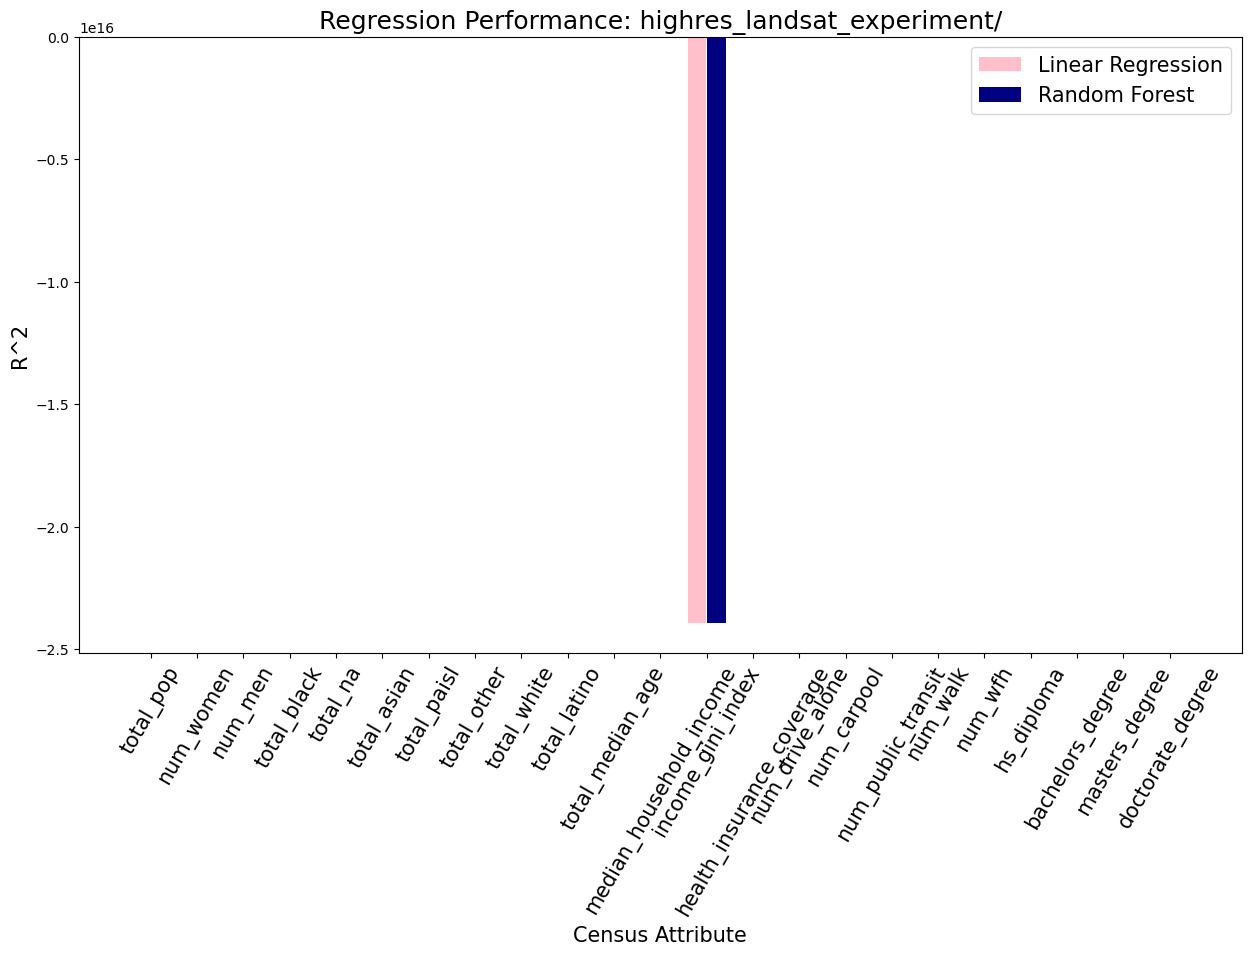

In [9]:
width = 0.40
x = np.arange(len(labels))

plt.figure(figsize=(15, 8))
plt.bar(x-0.21, logistic, width, label='Linear Regression', color='pink')
plt.bar(x+0.21, rf, width, label='Random Forest', color='navy')

plt.xticks(ticks=x, labels=predict_labels, rotation=60, fontsize=15)
plt.ylabel('R^2', fontsize=15)
plt.xlabel('Census Attribute', fontsize=15)
plt.legend(fontsize=15)
plt.title(f'Regression Performance: {scenario}', fontsize=18)

plt.savefig(savedir + 'pca_regression_accuracy')

# 2)  UMAP instead of PCA for dimensionality reduction

In [10]:
import umap
umap_reducer = umap.UMAP(n_neighbors=30, min_dist=0, n_components=100, metric='euclidean', random_state=42)

In [ ]:
stdoutOrigin=sys.stdout 
sys.stdout = open(savedir + 'ML_UMAP_regression_log.txt', "w")
title=f'Regression - {scenario} - UMAP'
logistic, rf, labels = train_test(df_emb, title, model1=LinearRegression(), model2=RandomForestRegressor(), dim_reducer=umap_reducer, predict_labels=predict_labels)

sys.stdout.close()
sys.stdout=stdoutOrigin

In [ ]:
width = 0.40
x = np.arange(len(labels))

plt.figure(figsize=(15, 8))
plt.bar(x-0.21, logistic, width, label='Linear Regression', color='pink')
plt.bar(x+0.21, rf, width, label='Random Forest', color='navy')

plt.xticks(ticks=x, labels=predict_labels, rotation=60, fontsize=15)
plt.ylabel('R^2', fontsize=15)
plt.xlabel('Census Attribute', fontsize=15)
plt.legend(fontsize=15)
plt.title(f'Regression Performance: {scenario}', fontsize=18)

plt.savefig(savedir + 'umap_regression_accuracy')